# SPRINT 8.1 (Juanjo Montero)

## Nivel 1 - Ejercicio 0
### Conexión en Python con MySQL y carga de tablas

Los paquetes necesarios a importar serán _sqlalchemy_ y _pymysql_ para la conexión, y _pandas_ para el tratado de los datos una vez importados desde la base de datos MySQL.

In [1]:
#pip install sqlalchemy pymysql pandas

Se decide trabajar con **sqlalchemy** ya que presenta una mayor compatibilidad con pandas, pero alternativamente se puede realizar la conexión utilizando _mysql-connector-python_.

SQLAlchemy funciona a través de la creación de un 'engine' al que se le pasan las credenciales de la base de datos (en nuestro caso nos conectamos con el usuario root, a la base de datos que creamos durante el sprint 5, llamada **sprint5** y alojada en la máquina local (_localhost_).

In [2]:
import pandas as pd
from sqlalchemy import create_engine, MetaData
from sqlalchemy.exc import SQLAlchemyError

user = 'root'
password = ####################
host = 'localhost'
database = 'sprint5'

try:
    my_database = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}')    

    connection = my_database.connect()
    print("Conexión realizada con éxito.")

except SQLAlchemyError as err:
    print(f"Error: {err}")
    
finally:
    if 'connection' in locals() and connection:
        connection.close()
        print("La conexión con la base de datos se cerró correctamente.")

Conexión realizada con éxito.
La conexión con la base de datos se cerró correctamente.


El engine creado se guarda bajo el nombre **my_database**. A continuación se genera un objeto MetaData al que se vincula con el engine:

In [3]:
metadata = MetaData()

metadata.reflect(bind=my_database)

El atributo **tables** del objeto _metadata_ creado es un diccionario con información sobre cada una de las tablas de la base de datos.
Las claves de este diccionario son el nombre de cada tabla, por lo que podemos utilizarlas como iterador en un bucle para cargar todas las tablas como DataFrames y almacenarlas en el diccionario **sprint8**.

In [4]:
sprint8 = {}

for table_name in metadata.tables:
    df = pd.read_sql_table(table_name, con=my_database)
    sprint8[table_name] = df
    print(f"La tabla '{table_name}' se importó correctamente.")

La tabla 'companies' se importó correctamente.
La tabla 'credit_cards' se importó correctamente.
La tabla 'products' se importó correctamente.
La tabla 'transaction_product' se importó correctamente.
La tabla 'transactions' se importó correctamente.
La tabla 'users' se importó correctamente.


Una vez hemos cargado todas las tablas correctamente, procedemos a la preparación de los dataframes para su análisis.

***

### Preparación de los dataframes

El primero de los dataframes a manipular es la tabla de hechos **transacciones**.
La cargamos desde el diccionario donde hemos almacenado todas las tablas de la base de datos:

In [5]:
transacciones = sprint8['transactions']

Para evitar colisiones con los nombres de columna de las otras tablas, se renombra la columna **id**:

In [6]:
transacciones.rename(columns={'id' : 'transaction_id'}, inplace=True)

Se calcula la cantidad de productos en cada pedido, utilizando la columna 'product_ids' y se almacena en la nueva columna **'num_prods'**.
También se extrae desde timestamps los valores de fecha **año**, **mes**, **semana del año** y **nombre del día de la semana**. Esto se realiza utilizando las funciones del accesor *dt* para manipular valores de fecha.

In [7]:
transacciones['num_prods'] = transacciones['product_ids'].str.split(',').apply(len)
transacciones['transaction_year'] = transacciones['timestamp'].dt.year
transacciones['transaction_month'] = transacciones['timestamp'].dt.month
transacciones['transaction_week'] = transacciones['timestamp'].dt.isocalendar().week
transacciones['transaction_weekday'] = transacciones['timestamp'].dt.day_name()

Para indicar el estado de la transacción se estaban utilizando los valores 0 (para transacciones aceptadas) y 1 (para las rechazadas) en la base de datos original. Con el fin de evitar confusiones y expresar este dato de manera más clara, se crea una una mueva columna **status** con los posibles valores **Accepted** o **Declined**. Esto se hace a través de una función lambda que se aplica a lo largo de todas las filas de la tabla.

In [8]:
calculate_status = lambda declined : 'Accepted' if (declined==0) else 'Declined'

transacciones['status'] = transacciones['declined'].apply(calculate_status)

Se convierte a tipo de datos texto (object) aquellas columnas con valores numéricos para los que no tiene sentido aplicar funciones matemáticas, como por ejemplo los distintos identificadores.

In [9]:
transacciones['transaction_id'] = transacciones['transaction_id'].astype(object)
transacciones['company_id'] = transacciones['company_id'].astype(object)
transacciones['user_id'] = transacciones['user_id'].astype(object)
transacciones['status'] = transacciones['status'].astype(object)


Finalmente, se seleccionan únicamente las columnas deseadas y se inspecciona el dataframe definitivo a usando **info()** y **display()**

In [10]:
transacciones = transacciones[['transaction_id', 'company_id', 'user_id', 'timestamp', 'amount', 'num_prods', 'status', 'transaction_year', 'transaction_month', 'transaction_week', 'transaction_weekday']]

In [11]:
transacciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   transaction_id       587 non-null    object        
 1   company_id           587 non-null    object        
 2   user_id              587 non-null    object        
 3   timestamp            587 non-null    datetime64[ns]
 4   amount               587 non-null    float64       
 5   num_prods            587 non-null    int64         
 6   status               587 non-null    object        
 7   transaction_year     587 non-null    int32         
 8   transaction_month    587 non-null    int32         
 9   transaction_week     587 non-null    UInt32        
 10  transaction_weekday  587 non-null    object        
dtypes: UInt32(1), datetime64[ns](1), float64(1), int32(2), int64(1), object(5)
memory usage: 44.3+ KB


In [12]:
display(transacciones)

,transaction_id,company_id,user_id,timestamp,amount,num_prods,status,transaction_year,transaction_month,transaction_week,transaction_weekday
0,02C6201E-D90A-1859-B4EE-88D2986D3B02,b-2362,92,2021-08-28 23:42:24,466.92,3,Accepted,2021,8,34,Saturday
1,0466A42E-47CF-8D24-FD01-C0B689713128,b-2302,170,2021-07-26 07:29:18,49.53,3,Accepted,2021,7,30,Monday
2,063FBA79-99EC-66FB-29F7-25726D1764A5,b-2250,275,2022-01-06 21:25:27,92.61,4,Accepted,2022,1,1,Thursday
3,0668296C-CDB9-A883-76BC-2E4C44F8C8AE,b-2618,265,2022-01-26 02:07:14,394.18,3,Accepted,2022,1,4,Wednesday
4,06CD9AA5-9B42-D684-DDDD-A5E394FEBA99,b-2346,92,2021-10-26 23:00:01,279.93,2,Accepted,2021,10,43,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...
582,FD2E8957-414B-BEEC-E9AD-59AA7A8A6290,b-2390,272,2022-03-13 00:27:34,78.29,4,Accepted,2022,3,10,Sunday
583,FD89D51B-AE8D-77DC-E450-B8083FBD3187,b-2494,250,2022-03-16 02:35:05,200.72,4,Accepted,2022,3,11,Wednesday
584,FD9CBCCD-8E1E-8DA1-4606-7E3A6F3A5A65,b-2302,223,2021-06-13 11:41:17,42.32,1,Accepted,2021,6,23,Sunday
585,FE809ED4-2DB6-55AC-C915-929516E4646B,b-2302,185,2021-11-09 21:35:40,219.83,2,Accepted,2021,11,45,Tuesday


De manera similar, hacemos lo propio con el dataframe **empresas**: se copia el dataframe desde el diccionario sprint8, se renombran las columnas cuyo nombre puede colisionar con otras tablas y conservamos únicamente las columnas de interés.

In [13]:
empresas = sprint8['companies']

empresas.rename(columns={'id' : 'company_id',
                         'country' : 'company_country'},
                         inplace=True)

empresas = empresas[['company_id', 'company_name', 'company_country']]

Se inspecciona el dataframe resultante:

In [14]:
empresas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   company_id       100 non-null    object
 1   company_name     100 non-null    object
 2   company_country  100 non-null    object
dtypes: object(3)
memory usage: 2.5+ KB


In [15]:
display(empresas)

,company_id,company_name,company_country
0,b-2222,Ac Fermentum Incorporated,Germany
1,b-2226,Magna A Neque Industries,Australia
2,b-2230,Fusce Corp.,United States
3,b-2234,Convallis In Incorporated,Germany
4,b-2238,Ante Iaculis Nec Foundation,New Zealand
...,...,...,...
95,b-2602,Placerat LLP,Netherlands
96,b-2606,Sed Est Corp.,Canada
97,b-2610,Egestas Nunc Sed Limited,Italy
98,b-2614,Rutrum Non Inc.,Germany


Para el dataframe usuarios se procede de forma similar:

In [16]:
usuarios = sprint8['users']

In [17]:
usuarios.rename(columns={'id' : 'user_id',
                         'country' : 'user_country',
                         'birth_date' : 'user_birth_date'},
                         inplace = True)

Se convierte a tipo de dato fecha la columna con las fecha de nacimiento de los usuarios, de esta manera se puede calcular la edad de los mismos calculatndo la diferencia entre el año actual y el año de su fecha de nacimiento.

In [18]:
usuarios['user_id'] = usuarios['user_id'].astype('object')
usuarios['user_birth_date'] = pd.to_datetime(usuarios['user_birth_date'])

In [19]:
usuarios['user_age'] = pd.to_datetime('now').year - usuarios['user_birth_date'].dt.year

Finalmente se concatena el nombre y apellido del usuario en una sola columna, filtramos únicamente las columnas de interés y se inspecciona el dataframe una vez modificado.

In [20]:
usuarios['user_full_name'] = usuarios['name'] + ' ' + usuarios['surname']

In [21]:
usuarios = usuarios[['user_id', 'user_full_name', 'user_country', 'user_age']]

In [22]:
usuarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         275 non-null    object
 1   user_full_name  275 non-null    object
 2   user_country    275 non-null    object
 3   user_age        275 non-null    int32 
dtypes: int32(1), object(3)
memory usage: 7.6+ KB


In [23]:
display(usuarios)

,user_id,user_full_name,user_country,user_age
0,1,Zeus Gamble,United States,40
1,2,Garrett Mcconnell,United States,33
2,3,Ciaran Harrison,United States,27
3,4,Howard Stafford,United States,36
4,5,Hayfa Pierce,United States,27
...,...,...,...,...
270,271,Leandra Cherry,Canada,34
271,272,Hedwig Gilbert,Canada,34
272,273,Hilary Ferguson,Canada,44
273,274,Jameson Hunt,Canada,43


Ahora que las tablas han sido preparadas, se procede a su unión en una sola tabla. Esto se consigue utilizando el método **merge** propio de los DataFrames de pandas. Se utilizan las claves foráneas **company_id** y **user_id** para unir las tablas _empresas_ y _usuarios_ a la tabla _transacciones_.

In [24]:
transacciones_empresas = transacciones.merge(empresas, left_on='company_id', right_on='company_id', how='left')
transacciones_empresas_usuarios = transacciones_empresas.merge(usuarios, left_on='user_id', right_on='user_id', how='left')

La tabla final **trans_all** contiene todas las columnas de interés para **todas las transacciones**, indepedendientemente del estado de la transacción (aceptadas o rechazadas).

In [25]:
trans_all = transacciones_empresas_usuarios[['transaction_id','status','timestamp','amount','num_prods',
                                                 'company_id', 'company_name', 'company_country',
                                                 'user_id', 'user_full_name', 'user_age', 'user_country',
                                                 'transaction_year', 'transaction_month', 'transaction_week', 'transaction_weekday']]

In [26]:
trans_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   transaction_id       587 non-null    object        
 1   status               587 non-null    object        
 2   timestamp            587 non-null    datetime64[ns]
 3   amount               587 non-null    float64       
 4   num_prods            587 non-null    int64         
 5   company_id           587 non-null    object        
 6   company_name         587 non-null    object        
 7   company_country      587 non-null    object        
 8   user_id              587 non-null    object        
 9   user_full_name       587 non-null    object        
 10  user_age             587 non-null    int32         
 11  user_country         587 non-null    object        
 12  transaction_year     587 non-null    int32         
 13  transaction_month    587 non-null  

Adicionalmente, se genera un dataframe **trans_ok** con las mismas columnnas pero únicamente con las **transacciones aceptadas**. Filtramos el dataframe y se reinicializan los índices usando el método _reset_index_ para que estos estén numerados de forma continua.

In [27]:
trans_ok = trans_all[trans_all['status']=='Accepted'].reset_index(drop=True)

In [28]:
trans_ok.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   transaction_id       500 non-null    object        
 1   status               500 non-null    object        
 2   timestamp            500 non-null    datetime64[ns]
 3   amount               500 non-null    float64       
 4   num_prods            500 non-null    int64         
 5   company_id           500 non-null    object        
 6   company_name         500 non-null    object        
 7   company_country      500 non-null    object        
 8   user_id              500 non-null    object        
 9   user_full_name       500 non-null    object        
 10  user_age             500 non-null    int32         
 11  user_country         500 non-null    object        
 12  transaction_year     500 non-null    int32         
 13  transaction_month    500 non-null  

In [29]:
display(trans_ok)

,transaction_id,status,timestamp,amount,num_prods,company_id,company_name,company_country,user_id,user_full_name,user_age,user_country,transaction_year,transaction_month,transaction_week,transaction_weekday
0,02C6201E-D90A-1859-B4EE-88D2986D3B02,Accepted,2021-08-28 23:42:24,466.92,3,b-2362,Lorem Eu Incorporated,Canada,92,Lynn Riddle,41,United States,2021,8,34,Saturday
1,0466A42E-47CF-8D24-FD01-C0B689713128,Accepted,2021-07-26 07:29:18,49.53,3,b-2302,Nunc Interdum Incorporated,Germany,170,William Benjamin,38,United Kingdom,2021,7,30,Monday
2,063FBA79-99EC-66FB-29F7-25726D1764A5,Accepted,2022-01-06 21:25:27,92.61,4,b-2250,Amet Nulla Donec Corporation,Italy,275,Kenyon Hartman,43,Canada,2022,1,1,Thursday
3,0668296C-CDB9-A883-76BC-2E4C44F8C8AE,Accepted,2022-01-26 02:07:14,394.18,3,b-2618,Non Institute,United Kingdom,265,Chloe Keith,26,Canada,2022,1,4,Wednesday
4,06CD9AA5-9B42-D684-DDDD-A5E394FEBA99,Accepted,2021-10-26 23:00:01,279.93,2,b-2346,Ut Semper Foundation,Sweden,92,Lynn Riddle,41,United States,2021,10,43,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,FCE2AB9A-271D-2BDC-9E49-8DD92A373391,Accepted,2022-02-06 22:48:41,335.56,4,b-2302,Nunc Interdum Incorporated,Germany,152,Hakeem Alford,46,United Kingdom,2022,2,5,Sunday
496,FD2E8957-414B-BEEC-E9AD-59AA7A8A6290,Accepted,2022-03-13 00:27:34,78.29,4,b-2390,Neque Tellus Imperdiet Corp.,Ireland,272,Hedwig Gilbert,34,Canada,2022,3,10,Sunday
497,FD89D51B-AE8D-77DC-E450-B8083FBD3187,Accepted,2022-03-16 02:35:05,200.72,4,b-2494,Malesuada PC,Ireland,250,Hilda Levy,31,Canada,2022,3,11,Wednesday
498,FD9CBCCD-8E1E-8DA1-4606-7E3A6F3A5A65,Accepted,2021-06-13 11:41:17,42.32,1,b-2302,Nunc Interdum Incorporated,Germany,223,Linus Willis,33,Canada,2021,6,23,Sunday


Se sigue exactamente el mismo método para generar **trans_declined** que recoge únicamente aquellas **transacciones que fueron rechazadas**.

In [30]:
trans_declined = trans_all[trans_all['status'] == 'Declined'].reset_index(drop=True)

In [31]:
trans_declined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   transaction_id       87 non-null     object        
 1   status               87 non-null     object        
 2   timestamp            87 non-null     datetime64[ns]
 3   amount               87 non-null     float64       
 4   num_prods            87 non-null     int64         
 5   company_id           87 non-null     object        
 6   company_name         87 non-null     object        
 7   company_country      87 non-null     object        
 8   user_id              87 non-null     object        
 9   user_full_name       87 non-null     object        
 10  user_age             87 non-null     int32         
 11  user_country         87 non-null     object        
 12  transaction_year     87 non-null     int32         
 13  transaction_month    87 non-null     

In [32]:
display(trans_declined)

,transaction_id,status,timestamp,amount,num_prods,company_id,company_name,company_country,user_id,user_full_name,user_age,user_country,transaction_year,transaction_month,transaction_week,transaction_weekday
0,07A46D48-31A3-7E87-65B9-0DA902AD109F,Declined,2021-06-28 21:11:42,340.87,2,b-2386,Lacus Quisque Associates,United States,272,Hedwig Gilbert,34,Canada,2021,6,26,Monday
1,09DE92CE-6F27-2BB7-13B5-9385B2B3B8E2,Declined,2021-05-11 20:40:06,303.05,2,b-2298,Elit Etiam Laoreet Associates,Canada,275,Kenyon Hartman,43,Canada,2021,5,19,Tuesday
2,0BEB80B7-9D66-1707-CE4B-9DC7E71914B5,Declined,2022-03-04 14:54:35,288.81,4,b-2338,Magna Incorporated,New Zealand,272,Hedwig Gilbert,34,Canada,2022,3,9,Friday
3,0C7C3A33-9947-3BC1-846D-7BE3D0D17598,Declined,2021-04-10 20:58:41,103.44,2,b-2434,Tristique Neque Venenatis Institute,Sweden,272,Hedwig Gilbert,34,Canada,2021,4,14,Saturday
4,0CE957A6-CCAA-2B7A-6839-8A4B1B324853,Declined,2022-02-02 07:29:36,428.69,4,b-2506,Sapien Nunc Pulvinar LLP,New Zealand,269,Haley Fitzpatrick,29,Canada,2022,2,5,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,EAC77318-72E4-51E3-AB5A-9BCCBA39C8F2,Declined,2021-12-13 23:01:02,458.73,3,b-2406,Non Ante LLP,Sweden,272,Hedwig Gilbert,34,Canada,2021,12,50,Monday
83,ED1CFB7D-E626-CE54-57A1-A036778B5E1F,Declined,2021-11-28 23:27:04,230.41,3,b-2514,Cras Consulting,Belgium,268,Clark Olson,38,Canada,2021,11,47,Sunday
84,F28E106B-5418-4667-9514-2E2A823ECC65,Declined,2022-03-05 06:54:37,114.89,3,b-2462,Pede Ultrices Ltd,Belgium,272,Hedwig Gilbert,34,Canada,2022,3,9,Saturday
85,FBD7E0D6-BA6B-F5BC-0CA9-EA4B8760100C,Declined,2021-04-29 14:17:50,207.09,3,b-2418,Mauris Id Inc.,Ireland,272,Hedwig Gilbert,34,Canada,2021,4,17,Thursday


***

## Exportación a CSV

Una vez que los dataframes han sido preparados, son exportados a archivos CSV. Esto será útil para la carga de los mismos durante la realización del sprint 8.2.

Para ello, se utiliza el método to_csv de los DataFrames de _pandas_. Se pasa el parámetro _index=False_ para que no se exporten los índices de cada fila al archivo csv.

In [33]:
empresas = sprint8['companies']
tarjetas = sprint8['credit_cards']
productos = sprint8['products']
transacciones = sprint8['transactions']
transaccion_producto = sprint8['transaction_product']

In [34]:
empresas.to_csv('empresas.csv', index=False)
tarjetas.to_csv('tarjetas.csv', index=False)
productos.to_csv('productos.csv', index=False)
usuarios.to_csv('usuarios.csv', index=False)
transacciones.to_csv('transacciones.csv', index=False)
transaccion_producto.to_csv('transaccion_producto.csv', index=False)
trans_all.to_csv('trans_all.csv', index=False)
trans_ok.to_csv('trans_ok.csv', index=False)
trans_declined.to_csv('trans_declined.csv', index=False)

***

# Visualización

Para proceder a la visualización de los datos se importan **matplotlib** y **seaborn**, librerías de python específicas para la creación de gráficos.

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

## Nivel 1 - Ejercicio 1
### Una variable numérica

### Distribución de la edad de los usuarios:

Para analizar **la edad** de los usuarios se presenta un histograma utilizando la función de seaborn **distplot** que permite mostrar además del histograma, el KDE.

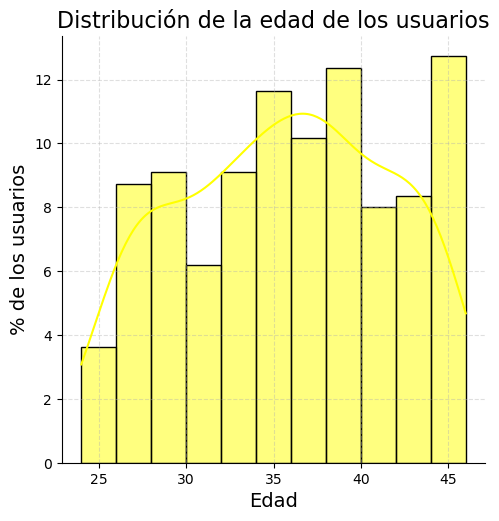

In [36]:
sns.displot(usuarios['user_age'], kde=True, stat='percent', bins=11, color='yellow')

plt.grid(True, linestyle='--', alpha=0.4)

plt.title("Distribución de la edad de los usuarios", fontsize=16)
plt.xlabel("Edad", fontsize=14)
plt.ylabel("% de los usuarios", fontsize=14)
plt.show()


Podemos ver que la edad de los usuarios está distribuida de manera bastante uniforme, con el pico de la distribución **entre los 35 y los 38 años**.

### Dsitribución del Importe de las ventas:

En cuanto al **importe de las ventas** (importe de las transacciones aceptadas), utilizaremos un *boxplot* para resumir este dato.



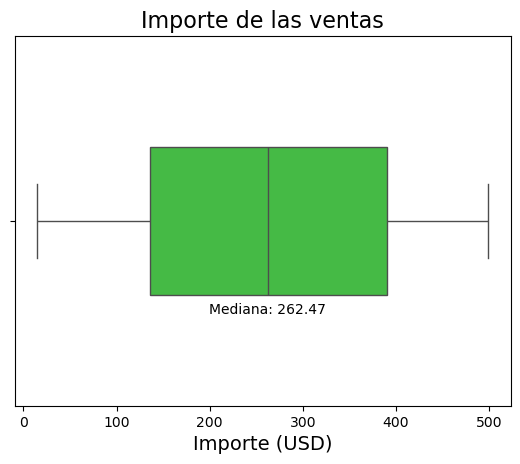

In [37]:
sns.boxplot(x=trans_ok.amount, width = 0.4, color='limegreen')

median = trans_ok.amount.median()
plt.text(median, 0.25, f'Mediana: {median}', horizontalalignment='center', fontsize=10)

plt.title("Importe de las ventas", fontsize=16)
plt.xlabel("Importe (USD)", fontsize=14)
plt.show()

El importe de las ventas está distribuido uniformemente, con la mediana en los **262.47 dólares**.

## Nivel 1 - Ejercicio 2
### Dos variables numéricas.

### ¿Existe alguna relación entre la edad de los usuarios y el importe gastado? 

Se grafica mediante un **scatterplot** la edad de los usuarios contra el importe de las transacciones.


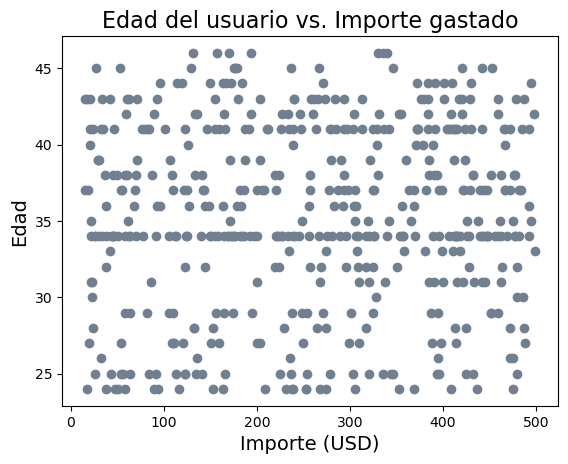

In [38]:
plt.scatter(trans_ok.amount, trans_ok.user_age,  color='slategray')

plt.title("Edad del usuario vs. Importe gastado", fontsize=16)
plt.xlabel("Importe (USD)", fontsize=14)
plt.ylabel("Edad", fontsize=14)
plt.show()


No parece que exista ningún tipo de correlación entre estos dos datos (como por ejemplo, que los usuarios más mayores hicieran compras más grandes).

### ¿Cómo evoluciona el importe medio de las ventas a lo largo del año?

Con la función **lineplot** de seaborn se grafica la evolución del importe medio.



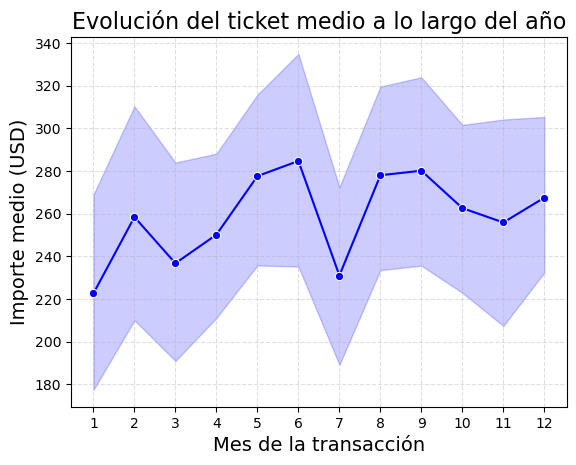

In [39]:
sns.lineplot(data=trans_ok, 
             x='transaction_month', 
             y='amount', 
             marker='o', color='blue')

plt.xticks(range(1,13))
plt.grid(True, linestyle='--', alpha=0.4)

plt.title("Evolución del ticket medio a lo largo del año", fontsize=16)
plt.xlabel("Mes de la transacción", fontsize=14)
plt.ylabel("Importe medio (USD)", fontsize=14)
plt.show()

Se puede ver que el importe medio tiene su mejor dato en el mes de junio y presenta sus puntos bajos en los meses de enero y julio. Estos puntos se analizarán con más detalle más adelante.

## Nivel 1 - Ejercicio 3
### Una variable categórica.

### ¿Qué porcentaje de transacciones están siendo rechazadas?

Se estudia la variable categórica **status**. Se utiliza un **pie chart** mediante el método _plot_ propio de los DataFrames de _pandas_ para mostrar la proporción de transacciones que están siendo aceptadas y rechazadas. A lo largo del informe se utilizará la misma paleta de colores para diferenciar el estado de las transacciones siempre que sea necesario.

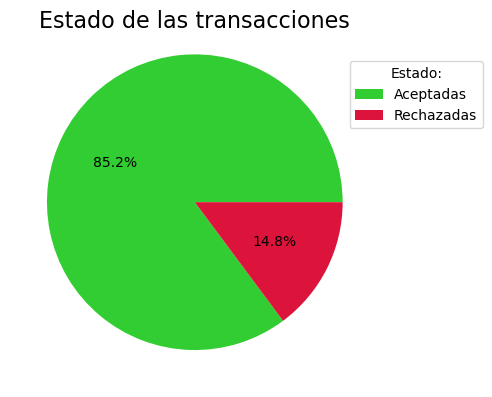

In [40]:
trans_all.status.value_counts().plot(kind='pie', 
                                     colors=['limegreen','crimson'],
                                     labels= None,
                                     autopct='%1.1f%%')

plt.legend(['Aceptadas','Rechazadas'], title='Estado:', bbox_to_anchor=(0.9,0.9))

plt.title("Estado de las transacciones", fontsize=16, y=0.95)
plt.ylabel(None)
plt.show()

### ¿Las empresas de qué países realizan el mayor número de transacciones?

La función _countplot_ de Seaborn genera un gráfico de barras con las frecuencias de cada país en la tabla de transacciones. Se ordenan las barras de mayor a menor con el parámetro _order_.  Se especifica el orden de impresión con el parámetro _zorder_ para hacer que las barras queden sobre el _grid_. 

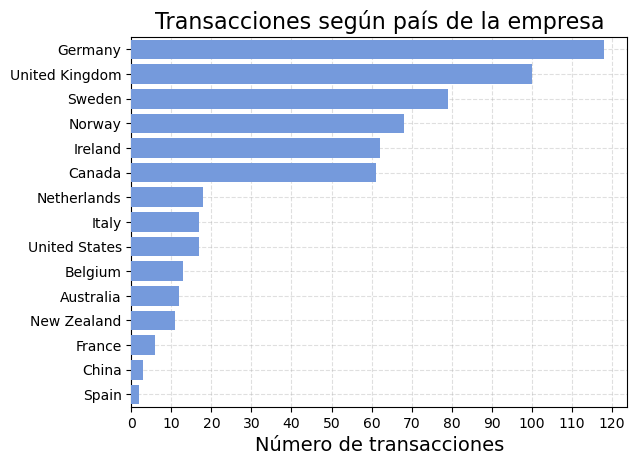

In [41]:
sns.countplot(data=trans_all['company_country'],
              order=trans_all['company_country'].value_counts().index,
              color='cornflowerblue',
              zorder=3)

plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(range(0,121,10))

plt.title("Transacciones según país de la empresa", fontsize=16)
plt.xlabel("Número de transacciones", fontsize=14)
plt.ylabel(None)
plt.show()


Categorizando las transacciones según la variable **company_country**, podemos ver que hay seis países que dominan el mercado de manera clara: **Alemania, Reino Unido, Suecia, Noruega, Irlanda y Canada**.


## Nivel 1 - Ejercicio 4
### Una variable categórica y una numérica.

### ¿Qué empresas están vendiendo más productos?

Agrupando el número de productos vendidos (variable numérica) por empresa (variable categórica), se elabora un ranking con las empresas que más productos han vendido. 

In [42]:
numprods_per_company = trans_ok.groupby('company_name')['num_prods'].sum()

Dado el elevado número de empresas, se limita la observación únicamente a las 10 empresas con más unidades vendidas:

In [43]:
numprods_top10companies = numprods_per_company.sort_values(ascending=False).head(10)

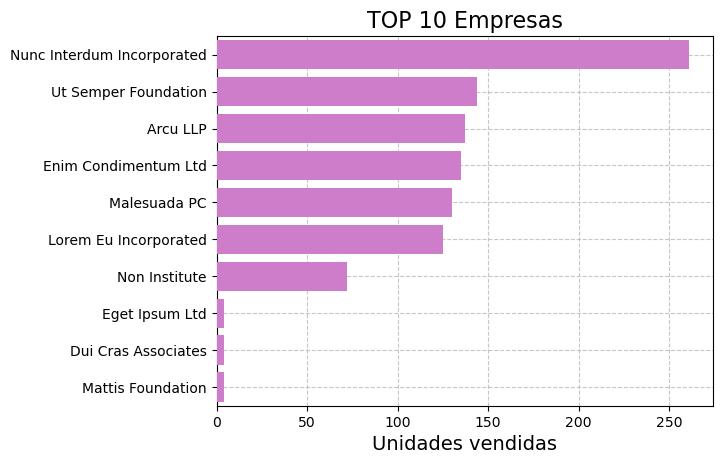

In [44]:
sns.barplot(data=numprods_top10companies, 
            orient='h',zorder=3, color='orchid')

plt.grid( linestyle='--', alpha=0.7)

plt.title('TOP 10 Empresas', fontsize=16)
plt.xlabel('Unidades vendidas', fontsize=14)
plt.ylabel(None)
plt.show()

Se puede apreciar que de las 100 empresas que existen en la base de datos, 7 de ellas han vendido practicamente la totalidad de los productos, con la empresa **Nunc Interdum Incorporated** destacando claramente por encima de las demás.

### Ventas desglosadas por días de la semana



Nótese que solamente se tienen en cuenta las transacciones aceptadas. Se agrupa **amount** por el día de la semana en que se produjo la transacción. Para especificar el orden de los días, se establecen los índices del dataframe usando el método **reindex** al que se le pasa una lista con el orden deseado.

In [45]:
sales_per_dayoftheweek = trans_ok.groupby('transaction_weekday')['amount'].sum()

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_per_dayoftheweek = sales_per_dayoftheweek.reindex(order)

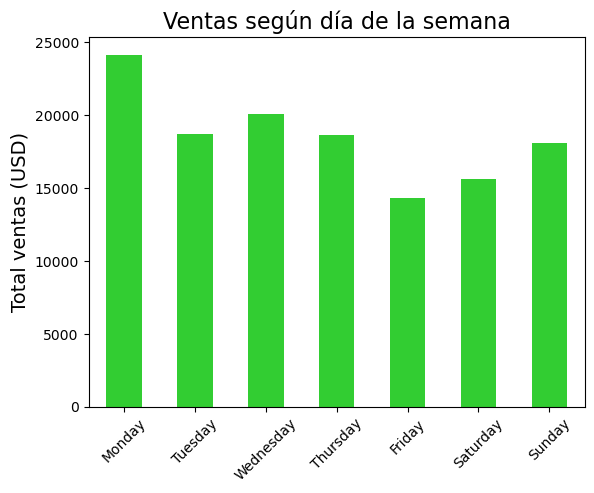

In [46]:
sales_per_dayoftheweek.plot(kind='bar', color='limegreen')
plt.xticks(rotation=45)

plt.title('Ventas según día de la semana', fontsize=16)
plt.xlabel(None)
plt.ylabel('Total ventas (USD)', fontsize=14)
plt.show()

Si separamos el total de ventas según el día de la semana, podemos ver que el lunes es el día en que más se ha vendido y jueves el día con el importe vendido más bajo.

### ¿Cómo es el gasto de los usuarios según su país?

Exploramos el gasto de los usuarios,a través de un **boxplot** para cada uno de los tres países en que se están realizando ventas: Estados Unidos, Reino Unido y Canadá.



Para separar y colorear de un tono distinto cada uno de los boxplots se pasa la variable _user_country_ como parámetro **hue** de los gráficos boxplot.

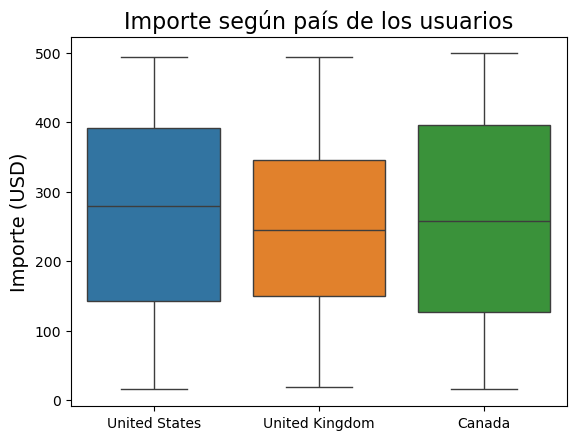

In [47]:
sns.boxplot(data=trans_ok,
            x='user_country',
            y='amount',
            hue='user_country')

plt.title("Importe según país de los usuarios", fontsize=16)
plt.xlabel(None)
plt.ylabel("Importe (USD)", fontsize=14)
plt.show()

No existen grandes diferencias en el gasto según el país, si bien en Estados Unidos el gasto es sutílmente más elevado. El gasto de los usuarios de Reino Unido está más concentrado alrededor de la mediana, con menor dispersión.

## Nivel 1 - Ejercicio 5

### Dos variables categóricas.

### Estado de las transacciones según el origen de los usuarios

¿Están las transacciones rechazadas distribuidas uniformemente entre los usuarios de distintos países?

Para mostrar estos datos, se realiza un gráfico de barras apiladas, donde las columnas son los países desde compran los usuarios. Las columnas están segmentadas según el estado de la transacción. Para conseguir el efecto de las barras apiladas, se deben pasar primero los datos a una tabla de contingencia utilizando la función de _pandas_ **crosstab**. De nuevo usamos la misma paleta (verde para transacciones aceptas y rojo para las rechazadas).

In [48]:
crosstab_country_declined = pd.crosstab(trans_all['user_country'], trans_all['status'])

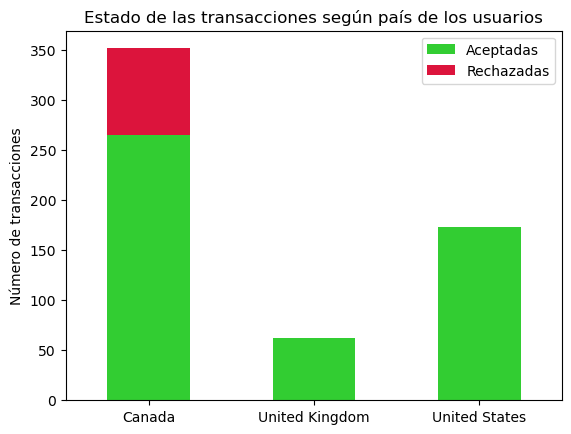

In [49]:
crosstab_country_declined.plot(kind='bar', stacked=True, color= ['limegreen', 'crimson'])

plt.xticks(rotation=0)

plt.title("Estado de las transacciones según país de los usuarios")
plt.xlabel(None)
plt.ylabel("Número de transacciones")
plt.legend(["Aceptadas", "Rechazadas"])
plt.show()


Al inspeccionar las transacciones segregadas por país, descubrimos que todas las transacciones rechazadas se han producido en Canadá. Vamos a ver si además se han producido todas en un mismo momento, con el siguiente análisis.

### Todas las transacciones rechazadas se produjeron en Canadá, ¿se produjeron además de manera puntual?

Vamos a ver si las transacciones rechazadas están concentradas en un solo punto del tiempo o sin embargo se han estado produciendo de manera sistemática a lo largo de los meses.

De manera similar al análisis por países, vamos a realizar un gráfico de barras apiladas, esta vez segregando por el **mes en que se produjeron las transacciones**. Para esto debemos preparar previamente una *tabla de contingencia.*

In [50]:
crosstab_month_status = pd.crosstab(trans_all.transaction_month, trans_all.status)

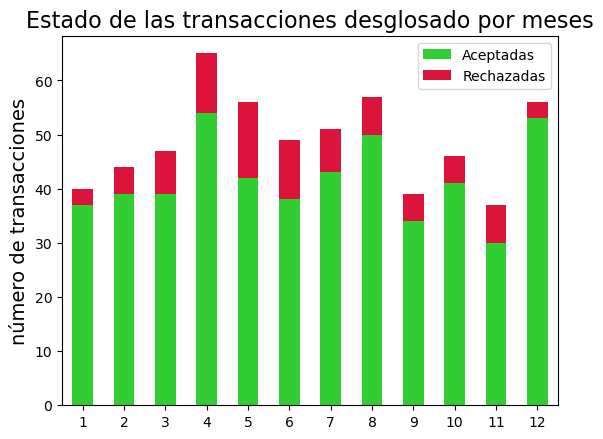

In [51]:
crosstab_month_status.plot(kind='bar', stacked=True, color= ['limegreen', 'crimson'])

plt.xticks(rotation=0)

plt.title("Estado de las transacciones desglosado por meses", fontsize=16)
plt.xlabel(None)
plt.ylabel("número de transacciones", fontsize=14)
plt.legend(["Aceptadas", "Rechazadas"])
plt.show()

Es posible apreciar que en los meses de **abril, mayo y junio** se produce un número mayor de transacciones rechazadas, pero estas se han estado produciendo sistemáticamente a lo largo del año. Sea cual sea el problema existente, es limitado a Canadá pero no ha sido de naturaleza puntual.

## Nivel 1 - Ejercicio 6

### Tres variables.

En el ejercicio 2 se ha explorado la evolución del ticket medio mes a mes donde se observa una bajada significativa para el **mes de julio**.
### ¿Afecta esta bajada por igual a los tres mercados en los que se están realizando ventas?

En esta ocasión vamos a segregar la evolución del ticket medio **por país**. 

Para mostrar estos datos se ha realizado un gráfico de líneas. Con el parámetro _errorbar=None_ retiramos los intervalos de confianza para cada línea ya que se superponen y traen mucho ruido al gráfico.



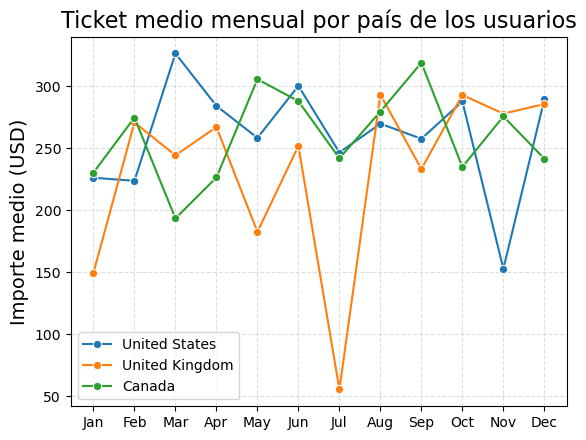

In [52]:
sns.lineplot(data=trans_ok,
            x='transaction_month',
            y='amount',
            hue='user_country',
            errorbar=None,
            marker='o')

plt.grid( linestyle='--', alpha=0.4)


plt.title("Ticket medio mensual por país de los usuarios", fontsize=16)
plt.xlabel(None)
plt.ylabel("Importe medio (USD)", fontsize=14)
plt.xticks(ticks=range(1,13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title=None)
plt.show()

Al segregar por país, vemos que la bajada del mes de junio se debe en gran parte a una **marcadísima caida del importe medio de las ventas en Reino Unido**. Otro pico negativo a tener en cuenta, aunque no tan alejado de la media, es el que se produce en noviembre pare el mercado de Estados Unidos.

## Nivel 1- Ejercicio 7
### Graficar un Pairplot.

Se realiza un pairplot con las variables numéricas. 

Se utiliza el estado de las transacciones como variable categórica aplicada al parámetro _hue_ para separarlas en dos colores diferenciados.

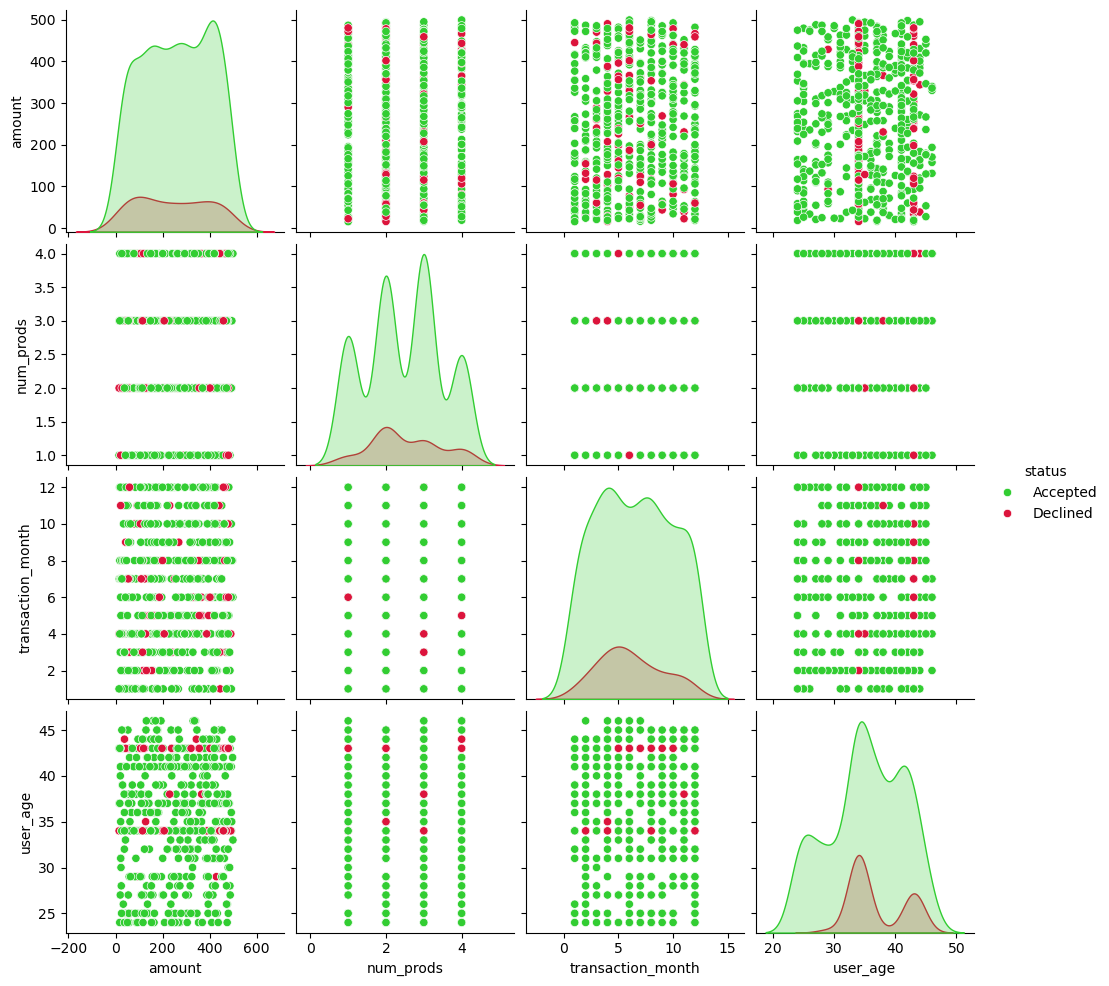

In [53]:
variables_to_pairplot = ['amount', 'num_prods', 'transaction_month', 'user_age', 'status']
sns.pairplot(trans_all[variables_to_pairplot], hue='status', palette=['limegreen','crimson'])
plt.show()

No parecen existir relaciones claras entre los distintos parámetros enfrentados. En el siguiente ejercicio se procede a calcular los coeficientes de correlación entre las distintas variables.

***

## Nivel 2 - Exercicio 1
### Correlación de las variables numéricas

Para calcular la correlación entre las distintas variables, se procede a graficar un mapa de calor utilizando la función **heatmap** de _seaborn_ en cojunción con el método **corr()** de los DataFrames de _pandas_.

Con el parámetro _annot_ (anotaciones) se muestran los valores de correlación sobre el mapa y se establecen los valores mínimos y máximos definiéndolos con _vmin_ y _vmax_. Adicionalmente, se elige un mapa de color (_cmap_) con dos extremos, para poder identicar visualmente correlaciones positivas (azul en este caso) o negativas (que se mostrarían en color rojo).

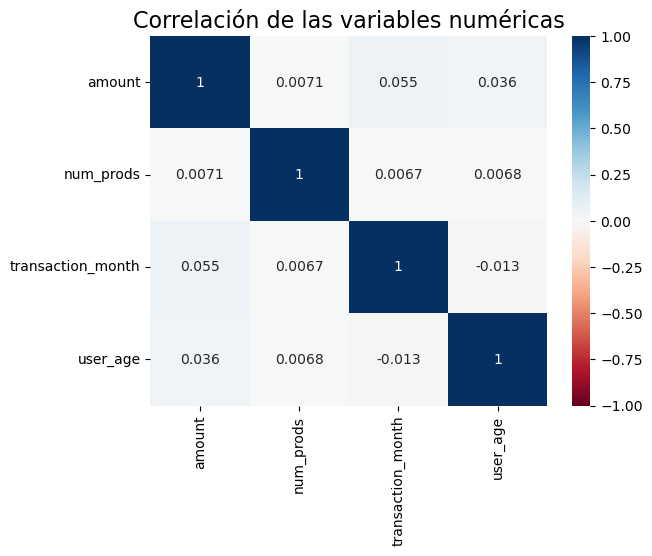

In [54]:
numeric_variables = trans_all[['amount', 'num_prods', 'transaction_month', 'user_age']]

sns.heatmap(numeric_variables.corr(), 
            annot=True, 
            vmin=-1, vmax=1,
            cmap='RdBu')

plt.title("Correlación de las variables numéricas", fontsize=16)
plt.show()

Como habíamos intuído previamente al graficar el _pairplot_, no existen correlaciones significativas para las variables estudiadas.

## Nivel 2 - Ejercicio 2
### Implementación de un jointplot

Se grafican importe y edad de los usuarios, segregando por color en base al estado de la transacción.

Para el importe de las transacciones, estos están distribuídos de manera bastante uniforme como ya sabíamos, tanto para las transacciones aceptadas como para las rechazadas.

En el caso de la edad, hay dos picos en transacciones realizadas por usuaricos con edades alrededor de los 34 y de los 43 años. En estos dos picos, las transacciones rechazadas suben acordemente con el número de transacciones aceptadas.

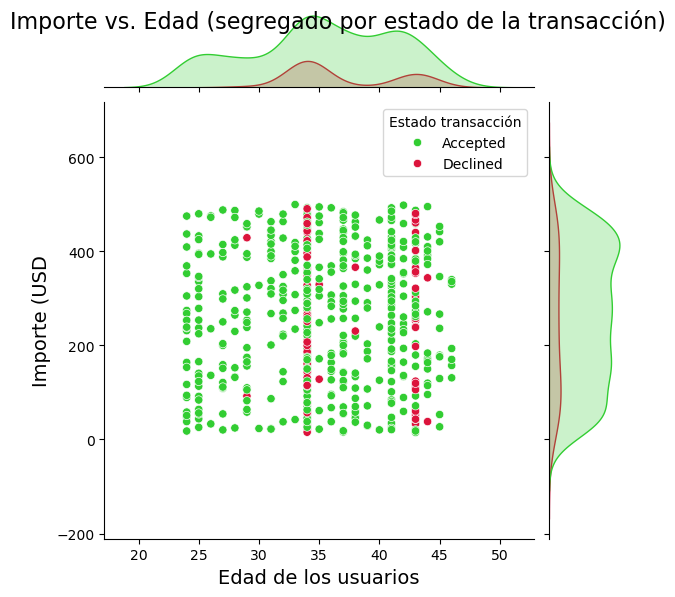

In [55]:
g = sns.jointplot(x = trans_all.user_age,
                  y = trans_all.amount,
                  hue = trans_all.status,
                  palette = ['limegreen', 'crimson'])

g.set_axis_labels("Edad de los usuarios", "Importe (USD", fontsize=14)

plt.suptitle("Importe vs. Edad (segregado por estado de la transacción)", fontsize=16)
plt.legend(title='Estado transacción')
plt.show()

***

## Nivel 3 - Ejercicio 1
### Implementación de un violinplot con otro tipo de gráfico

Se realizan 4 **violinplots**, en los que se representa la distribución del importe, para pedidos compuestos por **1, 2, 3 o 4 productos**.

Superpuesto a cada gráfico de violín, se muestra un **swarmplot** (muy similar al stripplot, pero con los puntos ordenados para evitar que se produzcan superposiciones entre ellos) en el que se ha coloreado cada punto en función de si se trata de una transacción aceptada o rechazada.

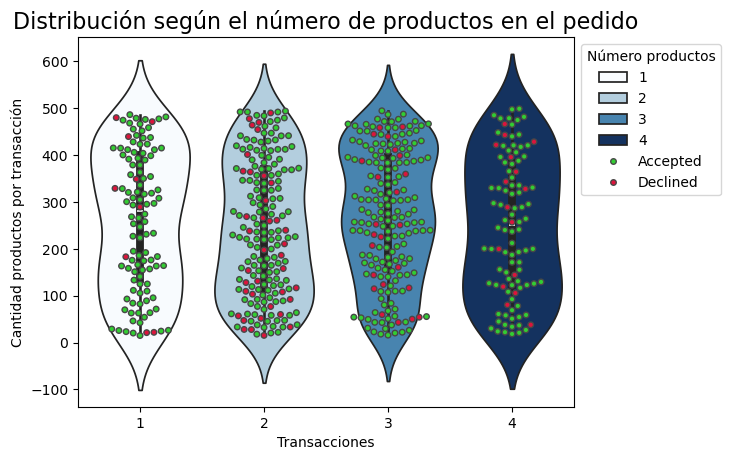

In [56]:
sns.violinplot(data=trans_all,
               x='num_prods', 
               y='amount', 
               hue='num_prods', 
               palette='Blues')

sns.swarmplot(data=trans_all,
              x='num_prods', 
              y='amount', 
              hue='status', 
              size=4, linewidth=1, palette=['limegreen', 'crimson'])

plt.legend(title='Número productos', bbox_to_anchor=(1,1))
plt.title('Distribución según el número de productos en el pedido', fontsize=16)
plt.xlabel('Transacciones')
plt.ylabel('Cantidad productos por transacción')
plt.show()

## Nivel 3 - Ejercicio 2
### Generar un FacetGrid para visualizar múltiples aspectos de les datos simultáneamente.

El gráfico a _mapear_ es un histograma de transacciones (aceptadas y rechazadas, indicadadas por color).

Se busca estudiar las dimensiones **año de la transacción** (2021, 2022 en las filas) y **país del usuario** que realiza la compra (USA, UK, Canadá en las columnas). Dado que se mapean 3x2 dimensiones, el resultado final son 6 histogramas.

A la función **FacetGrid** de _seaborn_ se le indican los datos, que serie usar en las filas y columnas y con el parámetro _margin_titles_ se indica que se muestren los nombres de cada dimensión al borde del gráfico.



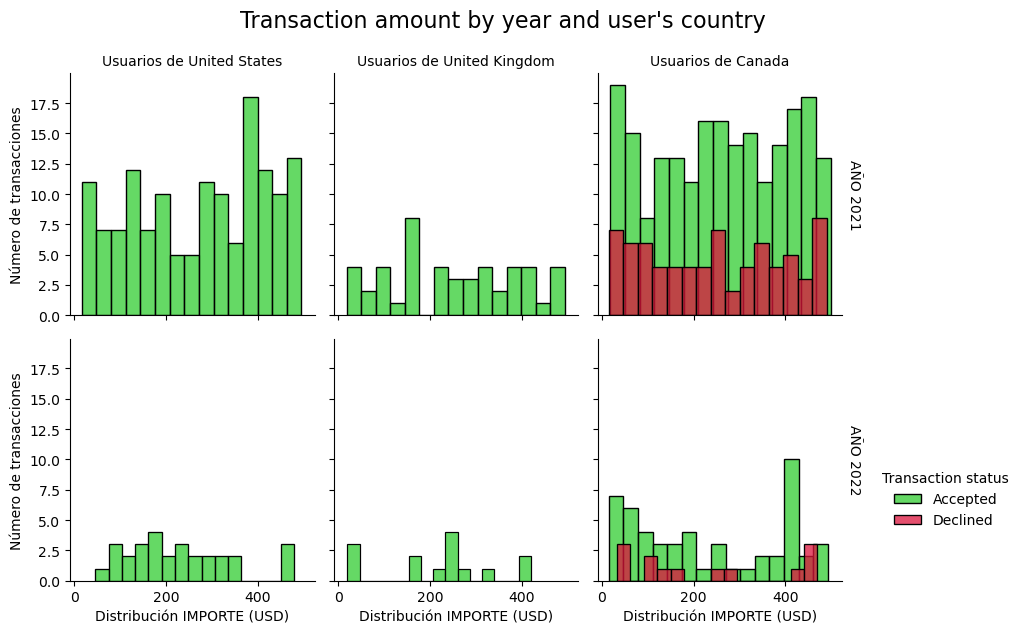

In [57]:
g = sns.FacetGrid(trans_all, 
                  col='user_country', 
                  row='transaction_year', 
                  hue='status', palette=['limegreen', 'crimson'], 
                  margin_titles=True)

g.map(sns.histplot, 'amount', bins=15)

g.add_legend(title='Transaction status',  loc='upper right', bbox_to_anchor=(1, 0.3))
g.fig.suptitle('Transaction amount by year and user\'s country', fontsize=16, y=1.05)
g.set_titles(col_template='Usuarios de {col_name}', row_template='AÑO {row_name}')
g.set_axis_labels('Distribución IMPORTE (USD)', 'Número de transacciones')

plt.show()

Este FacetGrid resume algunas de las caracterśticas más importantes de nuesto set de datos:
* Se tiene constancia de las transacciones para más meses del año 2021 que para el año 2022.
* Se producen más transacciones en los mercados estadounidenses y canadienses, en contraposición al mercado de Reino Unido.
* Todas las transacciones rechazadas se han producido en Canadá.